In [25]:
source('source.r')

load('RStates/mld-0.1.rdata')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


Loading required package: R.matlab
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘R.matlab’”Loading required package: geosphere
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘geosphere’”

In [2]:
ctd = read.xlsx('Raw Data/CTD/DataZoo - P1706 CTD Downcast Data.xlsx')
ctd$Time = conv_excel_time(ctd$DateTime_GMT, tz = 'UTC')

ctd.log = read.xlsx('Raw Data/CTD/DataZoo - P1706 CTD Cast Log.xlsx', sheet='Data')

#ship.log = read.xlsx('Raw Data/CCEP1706 Event Log.xlsx')

str(ctd)
str(ctd.log)
#str(ship.log)

'data.frame':	41780 obs. of  35 variables:
 $ Cruise      : chr  "CCE-P1706" "CCE-P1706" "CCE-P1706" "CCE-P1706" ...
 $ Cycle       : chr  "Cycle0" "Cycle0" "Cycle0" "Cycle0" ...
 $ EventNo     : num  3 3 3 3 3 3 3 3 3 3 ...
 $ Cast        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ DateTime_GMT: num  42888 42888 42888 42888 42888 ...
 $ Direction   : chr  "down" "down" "down" "down" ...
 $ Pressure    : num  2 3 4 5 6 7 8 9 10 11 ...
 $ Depth       : num  1.99 2.98 3.97 4.96 5.96 ...
 $ T090C       : num  16.9 16.8 16.9 16.9 16.8 ...
 $ T190C       : num  16.8 16.8 16.9 16.9 16.8 ...
 $ Cond1       : num  4.3 4.29 4.3 4.3 4.29 ...
 $ Cond2       : num  4.29 4.29 4.3 4.3 4.3 ...
 $ Sal00       : num  33.4 33.4 33.4 33.4 33.4 ...
 $ Sal11       : num  33.4 33.4 33.4 33.4 33.4 ...
 $ OxymicroM   : num  195 196 195 195 195 ...
 $ OxyPerSat   : num  81 81.1 81 80.9 80.8 ...
 $ SurPAR      : num  8632 8632 8632 8632 8632 ...
 $ PAR         : num  1292 1053 887 775 688 ...
 $ Cpar        : num  0.1496

In [62]:
plot.cycle = function(cycle = 'Cycle0') {
    l = which(ctd$Cycle == cycle)
    plot(ctd$Sal00[l], ctd$Depth[l], pch=20, cex=0.8, col='#00000090', ylim=c(100,0), ylab='Depth',
         xaxs='i', yaxs='i', main=cycle, xlab='Fluor', xlim = c(32.8,34.1))
}
unique(ctd$Cycle)

[1] "Cycle0"    "Transect1" "Cycle1"    "Cycle2"    "Transect2" "Cycle3"   
 [7] "Transect3" "Cycle4"    "BBL"       "TransComp"

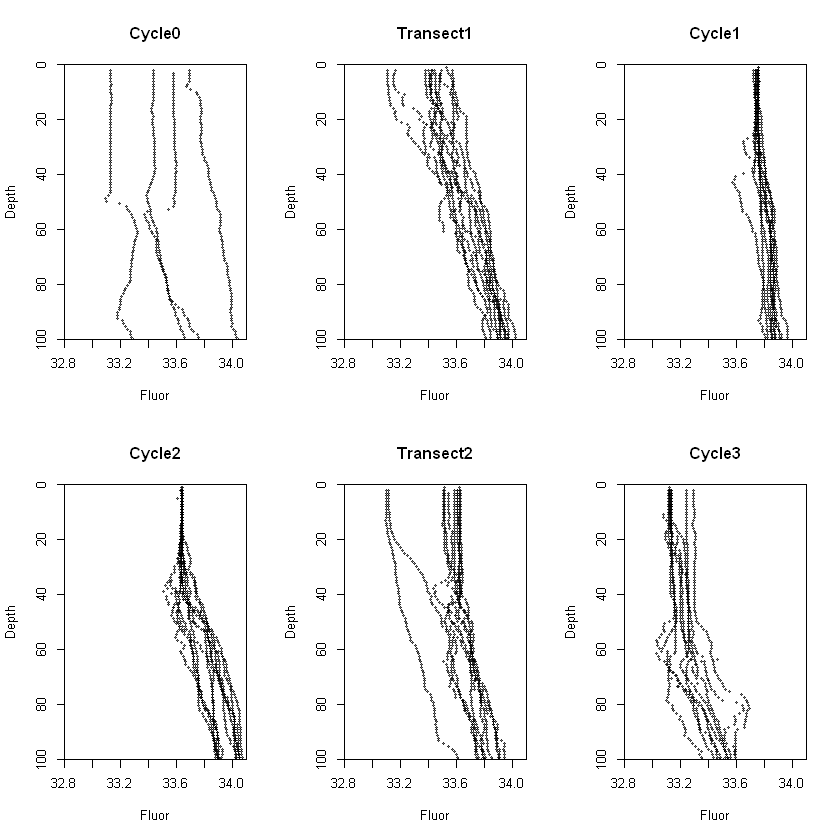

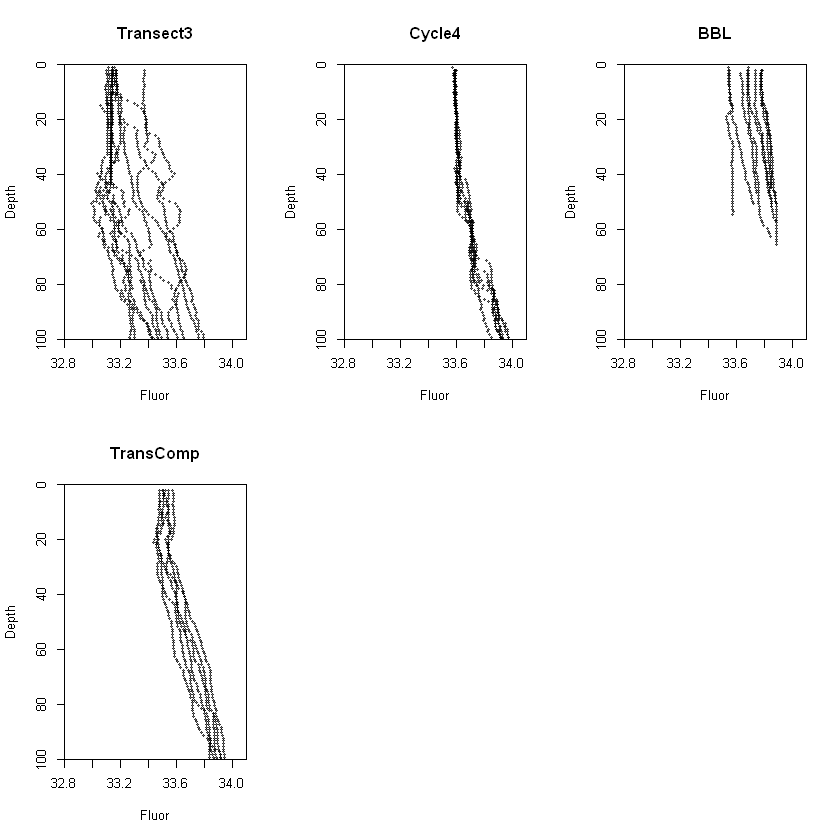

In [65]:
#pdf('Output/CTD/CTD Module - Summary of Sal Profiles per Cycle.pdf')

par(mfrow=c(2,3))
for (i in unique(ctd$Cycle)) {
    plot.cycle(i)
}

#dev.off()

In [33]:
trap.integrate = function(x, y, max) {
    l = order(x)
    s = x[l[1]] * y[l[1]]
    
    a2 = which(max < x[l])[1]  ## First depth that is greater than max
    a1 = which(max > x[rev(l)])[1]  ## Last depth less than max
    m = (y[l[a2]] - y[l[a1]]) / (x[l[a2]] - x[l[a1]])
    
    v.max = m * (max - x[l[a1]]) + y[l[a1]]
    
    y[l[a2]] = v.max
    x[l[a2]] = max
    
    for (i in 2:length(l)) {
        s = s + (x[l[i]] - x[l[i-1]]) * (y[l[i]] + y[l[i-1]]) / 2
        if (max == x[l[i]]) {
            return(mean = s / max)
        }
    }
    (s / x[l[length(l)]])
}

get.cast = function(cast, dir = 'down') {
    l = which(ctd$Cast == cast & ctd$Direction == dir)
    ctd[l,]
}

get.avg.temp = function(cast, mld) {
    l = which(ctd$Cast == cast & ctd$Direction == 'down')
    trap.integrate(ctd$Depth[l], ctd$T090C[l], mld)
}

get.avg.S = function(cast, mld) {
    l = which(ctd$Cast == cast & ctd$Direction == 'down')
    trap.integrate(ctd$Depth[l], ctd$Sal00[l], mld)
}


calc.cycle.avg = function(time = '2 am') {
    data = data.frame(Cycle = '', Cast = '', T = 0, S = 0, stringsAsFactors = FALSE)
    
    casts.times = which(ctd.log$Station.Type == time)

    for (i in unique(ctd.log$Cycle)) {
        l = which(ctd.log$Cycle == i)
        k = intersect(casts.times, l)  ## Which entries do we care about (cycle + 2am)

        if (length(k) > 0) {
            casts = ctd.log$Cast[k] ## Which casts

            for (j in casts) {  ## for each cast
                cast.mld = mld$mld[which(mld$Cast == j)]
                data = rbind(data, c(i, j, get.avg.temp(j, cast.mld), get.avg.S(j, cast.mld)))
            }   
        }
    }
    data = data[-1,]
    data
}

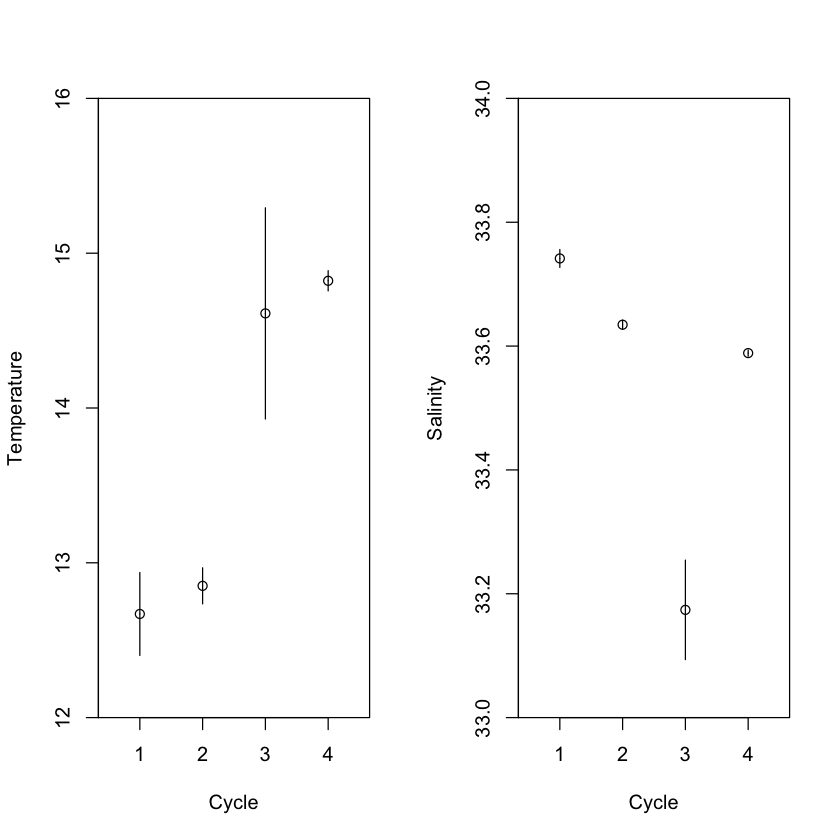

In [60]:
#pdf('Output/CTD Module - T and S cycle summary.pdf')

temp = calc.cycle.avg()

T.m = c()
T.s = c()
S.m = c()
S.s = c()

for (i in unique(temp$Cycle)) {
    l = which(temp$Cycle == i)
    
    T.m = c(T.m, mean(as.numeric(temp$T[l])))
    T.s = c(T.s, sd(temp$T[l]))
    S.m = c(S.m, mean(as.numeric(temp$S[l])))
    S.s = c(S.s, sd(temp$S[l]))
}
par(mfrow=c(1,2))

## Temperature
plot(NULL, NULL, xlim = c(0.5, 4.5), ylim = c(12, 16), ylab='Temperature', xlab='Cycle', yaxs='i')
points(c(1:4), T.m)
add.error.bars(c(1:4), rep(0,4), T.m, T.s)

## Salinity
plot(NULL, NULL, xlim = c(0.5, 4.5), ylim = c(33, 34), ylab='Salinity', xlab='Cycle', yaxs='i')
points(c(1:4), S.m)
add.error.bars(c(1:4), rep(0,4), S.m, S.s)

#dev.off()